psl


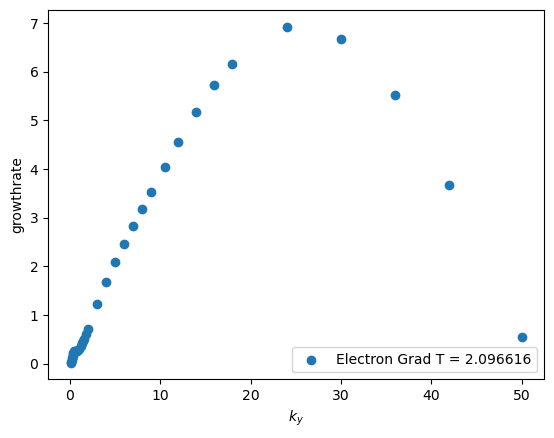

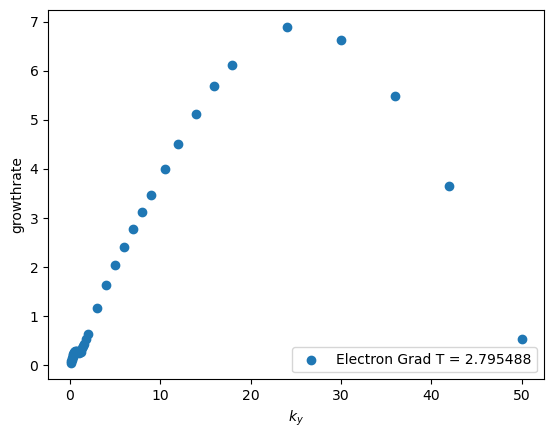

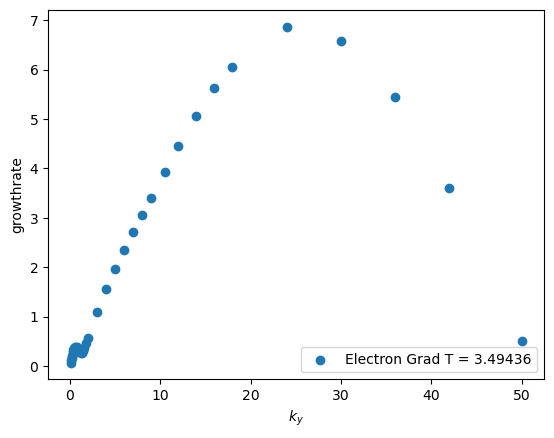

In [7]:
# from main import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import yaml
import argparse

def load_configuration(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
        config = argparse.Namespace(**config)
    return config

def parse_scan_log(scan_log_path=Path('/scratch/project_462000451/daniel/AUGUQ/scanfiles0002/scan.log')):
    # config_path = Path('/users/danieljordan/GENE_UncertaintyQuantification_NeuralNetworkSurrogate/code/config.yaml')
    # config = load_configuration(config_path)
    # scan_log_path = Path(config.diagdir, 'scan.log')
    growthrate = []
    frequency = []
    df = pd.read_csv(scan_log_path, sep='|',skiprows=1, names=['Run','omt2','omt1','kymin','Eiganvalues'])
    for i in range(len(df)):
        split = df['Eiganvalues'][i].lstrip().rstrip().split(' ')      
        growthrate.append(split[0])
        frequency.append(split[-1])
    df['growthrate'] = growthrate
    df['frequency'] = frequency
    df = df.drop(columns=['Run','Eiganvalues'])
    print('psl')
    return df

def plot_vs_ky(df, var='growthrate', omt1=2.096616, omt2=4.040331):
    mask = np.array(df['omt1']==omt1) * np.array(df['omt2']==omt2)
    var_df = df[var][mask]
    kymin_df = df['kymin'][mask]
    kymin_df = np.asarray(kymin_df,dtype='float')
    var_df = np.asarray(var_df,dtype='float')
    plt.scatter(kymin_df,var_df, label=f"Electron Grad T = {omt1}")
    plt.xlabel(r'$k_y$')
    plt.ylabel(var)
    plt.legend()
    plt.show()

df = parse_scan_log()
omt1 = pd.unique(df['omt1'])
for i in range(len(omt1)):
    plot_vs_ky(df, var='growthrate', omt1=omt1[i])


In [23]:
df.columns

Index(['#Run  | omt       2  | omt       1  | kymin     1  /Eigenvalue1            '], dtype='object')

In [16]:
from sklearn import svm 
import numpy.ma as ma

df2 = parse_scan_log(Path('/scratch/project_462000451/daniel/AUGUQ/scanfiles0003/scan.log'))

def growthrate_distribution(df, kymin):
    gr=np.asarray(df['growthrate'][df['kymin']==kymin], dtype='float')
    plt.hist(gr,density=False, bins=10)
    plt.ylabel('Frequency')
    plt.xlabel(f'{len(gr)} Growthrate Values')
    plt.title(f'ky = {kymin}')
    plt.show()

growthrate_distribution()


kys=pd.unique(df2['kymin'])

def growthrate_distribution_interp(df, kymin):
    df_ky = df[df['kymin']==kymin]
    data = list(zip(np.asarray(df_ky['omt1'],dtype='float'),np.asarray(df_ky['omt2'],dtype='float')))
    labels = np.asarray(df_ky['growthrate'],dtype='float')
    #check for nans
    if any(np.isnan(labels)):
        mask = ~np.isnan(labels)
        #remove nans
        data = [data[i] for i in range(len(mask)) if mask[i]]
        labels = labels[mask]
    #training on all the data
    regressor = svm.SVR()
    regressor.fit(data,labels)
    
    omt1 = np.linspace(np.min(df['omt1']), np.max(df['omt1']), 300)
    omt2 = np.linspace(np.min(df['omt2']), np.max(df['omt2']), 300)
    grid = np.meshgrid(omt1, omt2)
    # converting the grid into an array of points
    input_points = np.array(grid).reshape(2, -1).T
    growthrates = regressor.predict(input_points)

    print('Num of Grothrates',len(growthrates))
    plt.hist(growthrates)

growthrate_distribution_interp(df2, kys[0])

# mask = np.isnan(labels)

# #removing NANs
# data = [data[i] for i in range(len(mask)) if mask[i]]
# labels = ma.masked_array(labels, mask)

# print(len(data))
# print(len(labels))



psl
4.0
